Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing Skin Cancer Data:**

To do: Take necessary actions to read the data

**Importing all the important libraries:**


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.regularizers import l2

Using the data by mounting the google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_path="gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/"
test_path="gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Test/"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing


Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
tf.keras.utils.image_dataset_from_directory(data_dir_train,validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  label_mode="int",
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


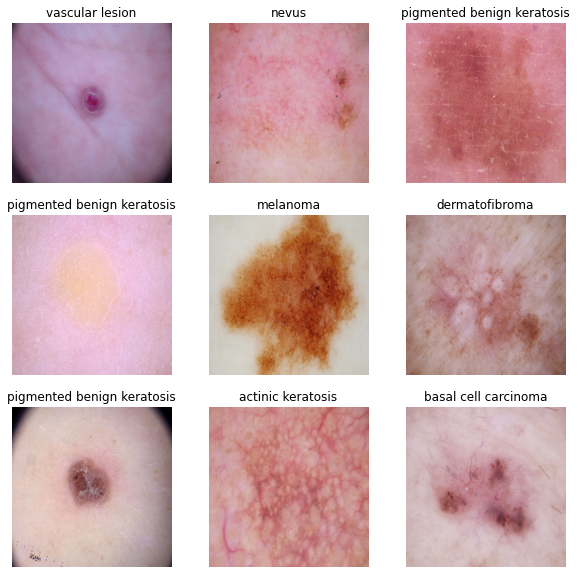

In [ ]:
import matplotlib.pyplot as plt

num_classes = 9

class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

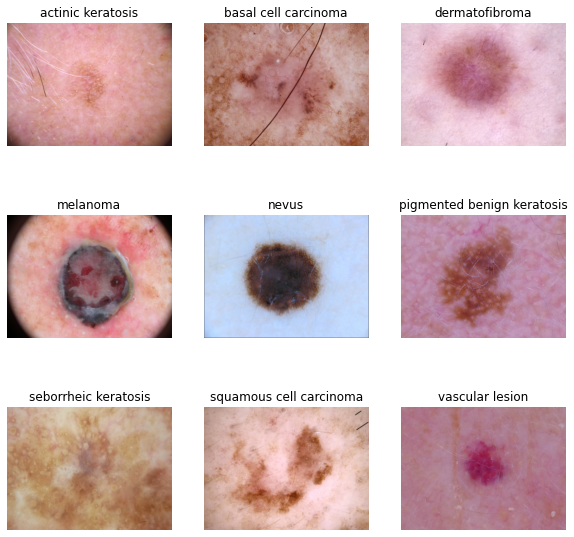

In [ ]:
plt.figure(figsize=(10,10))
for index,images in enumerate(class_names):
  
  temp=plt.imread(list(data_dir_train.glob('{}/*.jpg'.format(images)))[0])
  
  plt.subplot(3,3,index+1)
  plt.imshow(temp)
  plt.axis('off')
  plt.title(images)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

Model 1:

In [ ]:
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, (3, 3), padding='same',input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(len(class_names)))
model.add(Activation('softmax')) 

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
#model.compile(optimizer='sgd',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_4 (ModuleWra  (None, 180, 180, 16)     448       
 pper)                                                           
                                                                 
 module_wrapper_5 (ModuleWra  (None, 180, 180, 16)     0         
 pper)                                                           
                                                                 
 batch_normalization_2 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 module_wrapper_6 (ModuleWra  (None, 90, 90, 16)       0         
 pper)                                                

Training the model:

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 568s 4s/step - loss: 6.3175 - accuracy: 0.3376 - val_loss: 18.8477 - val_accuracy: 0.0537
Epoch 2/20
56/56 [==============================] - 82s 1s/step - loss: 1.4885 - accuracy: 0.4648 - val_loss: 25.4491 - val_accuracy: 0.0537
Epoch 3/20
56/56 [==============================] - 83s 1s/step - loss: 1.3003 - accuracy: 0.5324 - val_loss: 23.8507 - val_accuracy: 0.0537
Epoch 4/20
56/56 [==============================] - 83s 1s/step - loss: 1.1556 - accuracy: 0.5658 - val_loss: 16.6042 - val_accuracy: 0.1790
Epoch 5/20
56/56 [==============================] - 84s 2s/step - loss: 1.0052 - accuracy: 0.6306 - val_loss: 14.3987 - val_accuracy: 0.1723
Epoch 6/20
56/56 [==============================] - 82s 1s/step - loss: 0.8838 - accuracy: 0.6758 - val_loss: 12.0662 - val_accuracy: 0.2371
Epoch 7/20
56/56 [==============================] - 82s 1s/step - loss: 0.7771 - accuracy: 0.7076 - val_loss: 10.2825 - val_accuracy: 0.2953
Epoch 8/20
56/56 [=====

Visualizing the Training Results:

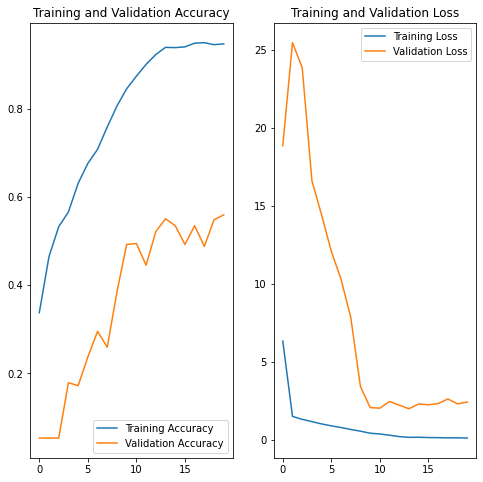

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Finding the Train Accuracy, Validation Accuracy, Loss and Validation Loss for the model 1:



In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly see that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 5s 349ms/step - loss: 2.4126 - accuracy: 0.5593
Accuracy:  0.9391741156578064
Validation Accuracy:  0.5592840909957886
Loss:  0.12761114537715912
Validation Loss 2.412597417831421


**Observations:**
* As we can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved around 93.9% accuracy on the training set.

* Training accuracy is increasing linearly over time, whereas validation accuracy stalls around 55.9% in the training process. 

* Also, the difference in accuracy between training and validation accuracy is noticeable which is a sign of overfitting.

**Write your findings here:**

To over come the over fitting we shall use data augmentation and add dropouts to the model.

Model 2:

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

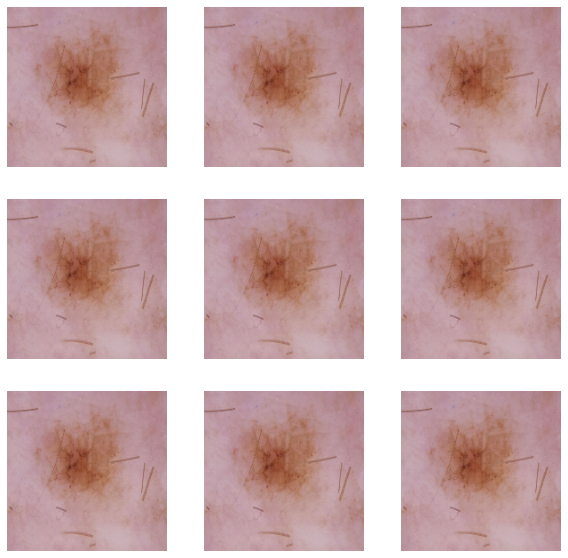

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential()
model.add(data_augmentation)
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, (3, 3), padding='same',input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax')) 

Compiling the Model:

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
## Your code goes here, note: train your model for 20 epochs
#history = ## your training code

epochs = 50
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 99s 2s/step - loss: 9.1515 - accuracy: 0.2997 - val_loss: 21.8670 - val_accuracy: 0.0336
Epoch 2/50
56/56 [==============================] - 95s 2s/step - loss: 1.8948 - accuracy: 0.3359 - val_loss: 29.1105 - val_accuracy: 0.1499
Epoch 3/50
56/56 [==============================] - 96s 2s/step - loss: 1.7129 - accuracy: 0.3878 - val_loss: 31.7676 - val_accuracy: 0.1499
Epoch 4/50
56/56 [==============================] - 97s 2s/step - loss: 1.6850 - accuracy: 0.4157 - val_loss: 31.4720 - val_accuracy: 0.1499
Epoch 5/50
56/56 [==============================] - 95s 2s/step - loss: 1.6424 - accuracy: 0.4319 - val_loss: 33.4453 - val_accuracy: 0.1499
Epoch 6/50
56/56 [==============================] - 96s 2s/step - loss: 1.6297 - accuracy: 0.4180 - val_loss: 24.2976 - val_accuracy: 0.1432
Epoch 7/50
56/56 [==============================] - 95s 2s/step - loss: 1.5947 - accuracy: 0.4464 - val_loss: 23.9714 - val_accuracy: 0.1499
Epoch 8/50
56/56 [======

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_18 (ModuleWr  (None, 180, 180, 16)     448       
 apper)                                                          
                                                                 
 module_wrapper_19 (ModuleWr  (None, 180, 180, 16)     0         
 apper)                                                          
                                                                 
 batch_normalization_5 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                      

Finding the Train Accuracy, Validation Accuracy, Loss and Validation Loss for the model 2:



In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 5s 351ms/step - loss: 3.8813 - accuracy: 0.3289
Accuracy:  0.3364955484867096
Validation Accuracy:  0.3288590610027313
Loss:  3.8056302070617676
Validation Loss 3.88126277923584


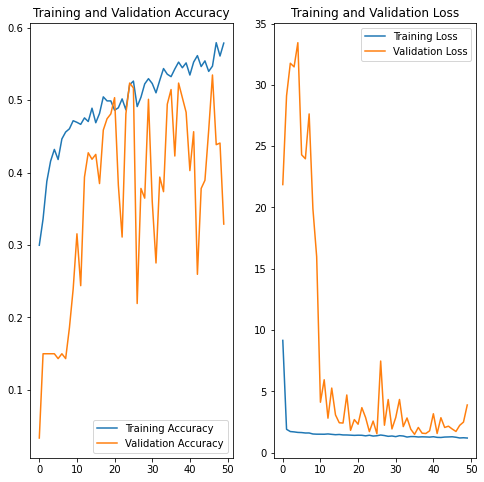

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

We have used 50 epochs here. We could see a very little difference in 
Train Accuracy:  33.64%
Validation Accuracy: 32.88%
But the model accuracy on training and validation has gone down considerably.

* Todo: Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
totalimages = []

N = 0  # total files
for dirpath, dirnames, filenames in os.walk(data_dir_train):
   #filecount = len(filenames) 
   if(len(filenames) > 0):
     totalimages.append(len(filenames))
   N_c = len(filenames)
   N += N_c
   print ("Files in ", dirpath, N_c)
print ("Total Files ",N)
image_ds = pd.DataFrame({"name":class_names, "totalimages":totalimages})

Files in  gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train 0
Files in  gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/nevus 357
Files in  gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/squamous cell carcinoma 181
Files in  gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/dermatofibroma 95
Files in  gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/pigmented benign keratosis 462
Files in  gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/seborrheic keratosis 77
Files in  gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/actinic keratosis 114
Files in  gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/basal cell carcinoma 376
Files in  gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/melanoma 438
Files in  gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/vascular lesion 139
Total Files  2239


* Todo: Write your findings here:
Which class has the least number of samples?

Ans: Class " seborrheic keratosis" has least number of samples = 77

- Which classes dominate the data in terms proportionate number of samples?

Ans : Classes like "pigmented benign keratosis", "melanoma", "basal cell carcinoma" and "nevus" dominate the data with max samples

Todo: Rectify the class imbalance

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
path_to_training_dataset= data_dir_train #"To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EA4EBBA10>: 100%|██████████| 500/500 [00:25<00:00, 19.95 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7EA3E12090>: 100%|██████████| 500/500 [00:22<00:00, 22.02 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7EA4AC8CD0>: 100%|██████████| 500/500 [00:23<00:00, 20.98 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7EA4BA9610>: 100%|██████████| 500/500 [01:38<00:00,  5.07 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F7EA4BA9690>: 100%|██████████| 500/500 [01:33<00:00,  5.34 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7EA3E4ED50>: 100%|██████████| 500/500 [00:25<00:00, 19.92 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7EA4B94050>: 100%|██████████| 500/500 [00:52<00:00,  9.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EA61F5D50>: 100%|██████████| 500/500 [00:23<00:00, 21.42 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7EA4046E50>: 100%|██████████| 500/500 [00:24<00:00, 20.59 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/nevus/output/nevus_original_ISIC_0000340.jpg_a59240a3-5fab-458c-9c8c-2acacc8591fd.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/nevus/output/nevus_original_ISIC_0000323.jpg_a449ed2f-804d-471b-b9bb-641ef1d2861d.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/nevus/output/nevus_original_ISIC_0027447.jpg_c4e52f9c-fbcf-46a7-9473-39edde026b92.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/nevus/output/nevus_original_ISIC_0000383.jpg_70ce1304-f08d-447a-a8f9-2c0a8b82fe83.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/nevus/output/nevus_original_ISIC_0000349.jpg_f2a80864-44ab-4fb0-8e98-0f61ca14787b.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/nevus/output/nevus_original_ISIC_0000319.jpg_c5f4a2a6-7b4c-4403-bdd2-6da865d8f446.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/nevus/output/nevus_original_ISIC_0000403.jpg_b4d9d4d

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [ ]:
path_list_new[1]

'gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train/nevus/output/nevus_original_ISIC_0000323.jpg_a449ed2f-804d-471b-b9bb-641ef1d2861d.jpg'

In [ ]:
new_df['Label'].value_counts()

nevus                         500
squamous cell carcinoma       500
dermatofibroma                500
pigmented benign keratosis    500
seborrheic keratosis          500
actinic keratosis             500
basal cell carcinoma          500
melanoma                      500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Todo: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Todo: Create a training dataset

In [ ]:
data_dir_train

PosixPath('gdrive/My Drive/Colab Notebooks/Melanoma Assignment/Train')

Todo: Create a training dataset

In [ ]:
data_dir_train =  data_dir_train # "path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",  ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Todo: Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Todo: Create your model (make sure to include normalization)

Moddel 3:

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#normalisation layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
# First Conv layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding ='same' ,input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding ='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dense(9,kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_36 (ModuleWr  (None, 180, 180, 16)     448       
 apper)                                                          
                                                                 
 module_wrapper_37 (ModuleWr  (None, 90, 90, 16)       0         
 apper)                                                          
                                                                 
 module_wrapper_38 (ModuleWr  (None, 90, 90, 32)       4640      
 apper)                                                          
                                                                 
 module_wrapper_39 (ModuleWr  (None, 45, 45, 32)       0         
 apper)                                               

Todo: Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## Your code goes here
from tensorflow.keras.optimizers import Adam
### Todo, choose an appropirate optimiser and loss function
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

Todo: Train your model

In [ ]:
#epochs = 30
## Your code goes here
#history = # your model fit code

epochs = 30
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 259s 2s/step - loss: 1.8657 - accuracy: 0.2839 - val_loss: 1.6367 - val_accuracy: 0.3749
Epoch 2/30
169/169 [==============================] - 254s 1s/step - loss: 1.5177 - accuracy: 0.4089 - val_loss: 1.4957 - val_accuracy: 0.4336
Epoch 3/30
169/169 [==============================] - 257s 2s/step - loss: 1.3731 - accuracy: 0.4674 - val_loss: 1.3104 - val_accuracy: 0.4959
Epoch 4/30
169/169 [==============================] - 255s 2s/step - loss: 1.2407 - accuracy: 0.5139 - val_loss: 1.1824 - val_accuracy: 0.5523
Epoch 5/30
169/169 [==============================] - 257s 2s/step - loss: 1.1379 - accuracy: 0.5686 - val_loss: 1.1045 - val_accuracy: 0.5887
Epoch 6/30
169/169 [==============================] - 256s 2s/step - loss: 0.9827 - accuracy: 0.6304 - val_loss: 1.1543 - val_accuracy: 0.5620
Epoch 7/30
169/169 [==============================] - 256s 2s/step - loss: 0.8499 - accuracy: 0.6792 - val_loss: 0.9173 - val_accuracy: 0.6696
Epoch 8/30

Visualize the Model Results:

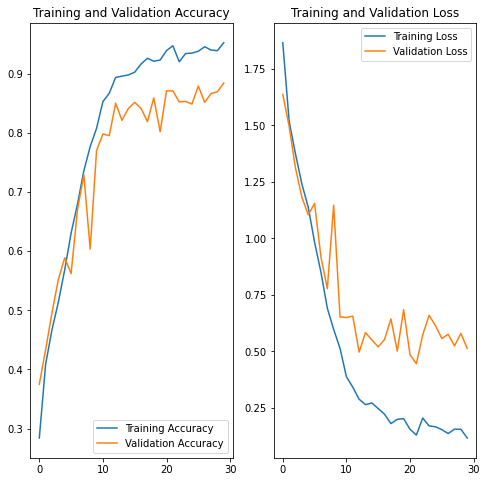

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Finding the Train Accuracy, Validation Accuracy, Loss and Validation Loss for the model 3:

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 21s 461ms/step - loss: 0.5125 - accuracy: 0.8842
Accuracy:  0.9619807004928589
Validation Accuracy:  0.8841871023178101
Loss:  0.09013120830059052
Validation Loss 0.5124621987342834


Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

* Final model has no overfitting or underfitting
* Training accuracy is 96.19 % and validation accuracy is 88.42 %
* It is observed that there is a significance improvement in training and validation accuracy after using Augmentor and treating imbalance of all the classes
* More epochs can be added to increase the accuracy Further
* Training and validation loss has been decreased with the increase in no of epochs